In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем датасет

In [ ]:
dataset_email = pathlib.Path("/content/drive/MyDrive/Kurushin1sem/email/")
dataset_resume = pathlib.Path("/content/drive/MyDrive/Kurushin1sem/resume/")
dataset_scientific = pathlib.Path("/content/drive/MyDrive/Kurushin1sem/scientific_publication/")

image_count_email = len(list(dataset_email.glob("*.png")))
image_count_resume = len(list(dataset_resume.glob("*.png")))
image_count_scientific = len(list(dataset_scientific.glob("*.png")))

print(f"Всего изображений email: {image_count_email} , Всего изображений resume: {image_count_resume}, Всего изображений scientific: {image_count_scientific}")

Всего изображений email: 105 , Всего изображений resume: 78, Всего изображений scientific: 102


Нейросеть

In [ ]:
batch_size = 5
img_width = 1000
img_height = 1000

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Kurushin1sem/",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Kurushin1sem/",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

class_names = train_ds.class_names
print(f"Class names: { class_names }")

#cache

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


Found 285 files belonging to 3 classes.
Using 228 files for training.
Found 285 files belonging to 3 classes.
Using 57 files for validation.
Class names: ['email', 'resume', 'scientific_publication']


Создаем модель, компилируем и выводим summary

In [ ]:
#create model

num_classes = len(class_names)
model = Sequential([
    #локлаьно
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),

    #аугментация
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2),
    #дальше везде одинаково
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),

    # регулиризация

    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

#компиляция модели

model.compile(
optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
metrics = ['accuracy'])

#print model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 1000, 1000, 3)     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 1000, 1000, 3)     0         
                                                                 
 random_rotation_1 (RandomR  (None, 1000, 1000, 3)     0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 1000, 1000, 3)     0         
                                                                 
 random_contrast_1 (RandomC  (None, 1000, 1000, 3)     0         
 ontrast)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 1000, 1000, 16)   

Обучение модели

Epoch 1/5
46/46 [==============================] - 476s 10s/step - loss: 1.0417 - accuracy: 0.5044 - val_loss: 2.3315 - val_accuracy: 0.2807
Epoch 2/5
46/46 [==============================] - 475s 10s/step - loss: 1.1286 - accuracy: 0.3904 - val_loss: 1.0627 - val_accuracy: 0.4211
Epoch 3/5
46/46 [==============================] - 474s 10s/step - loss: 1.0536 - accuracy: 0.4298 - val_loss: 1.0695 - val_accuracy: 0.3684
Epoch 4/5
46/46 [==============================] - 470s 10s/step - loss: 1.0288 - accuracy: 0.4518 - val_loss: 0.9621 - val_accuracy: 0.4737
Epoch 5/5
46/46 [==============================] - 496s 11s/step - loss: 1.0108 - accuracy: 0.4386 - val_loss: 1.0369 - val_accuracy: 0.5088


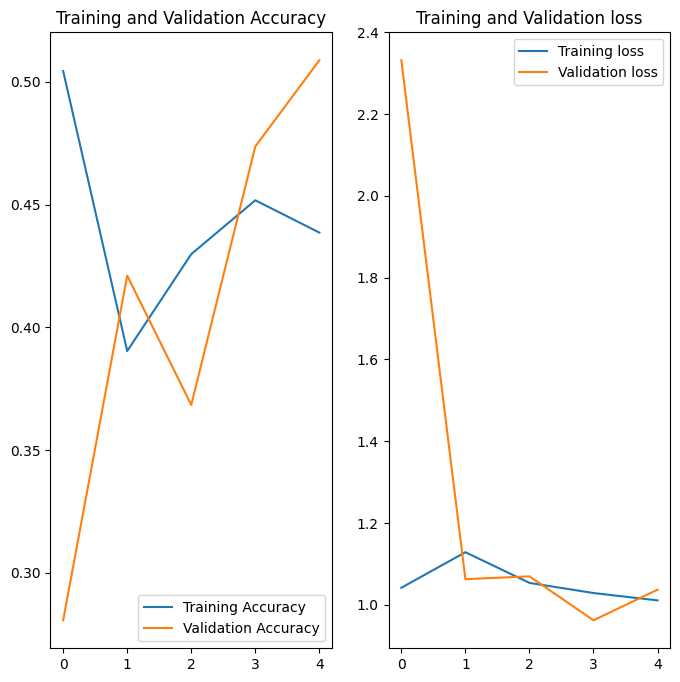

In [ ]:
#кол-во эпох обучения

epochs = 5
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

#Визуализируем Training и Validation результаты
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

Сохранение модели


In [ ]:
import os

gdrive_path = "/content/drive/My Drive/TestNeuro/"

filename = gdrive_path
model.save_weights('my_model_weights_V4.h5')
model.save(filename + 'my_model_V4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


загрузка модели

In [ ]:
from keras.models import load_model
model = load_model(filename + 'my_model.h5')

print(f"Загрузка завершена модели: { model }")

Загрузка завершена модели: <keras.src.engine.sequential.Sequential object at 0x7b065ab12fb0>


Загрузка изображения

In [74]:
import os
import shutil
from os import path

img_directory = "/content/drive/MyDrive/TestNeuro/"
img_name = "Res4.png"
img_directory_name = (img_directory + img_name)
img = tf.keras.utils.load_img(img_directory_name, target_size = (img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Сделаем предикаты

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

gdrive_path_email = "/content/drive/My Drive/TestNeuro/ReadyEmail/"
gdrive_path_resume = "/content/drive/My Drive/TestNeuro/ReadyResume/"
gdrive_path_science = "/content/drive/My Drive/TestNeuro/ReadyScience/"

emfile = (gdrive_path_email + img_name)
resfile = (gdrive_path_resume + img_name)
scfile = (gdrive_path_science + img_name)

# выводим результаты

print("На изображении скорее всего {} - {} ({:.2f}% вероятность)".format(
img_name,
class_names[np.argmax(score)],
100 * np.max(score)))

#фильтруем их

if(class_names[np.argmax(score)] == 'email') :

  shutil.copy(img_directory_name, emfile)

  print(shutil.copy(img_directory_name, emfile))

if(class_names[np.argmax(score)] == 'resume') :

  shutil.copy(img_directory_name, resfile)

  print(shutil.copy(img_directory_name, resfile))

if(class_names[np.argmax(score)] == 'scientific_publication') :

  shutil.copy(img_directory_name, scfile)

  print(shutil.copy(img_directory_name, scfile))


1/1 [==============================] - 0s 345ms/step
На изображении скорее всего Res4.png - resume (39.34% вероятность)
/content/drive/My Drive/TestNeuro/ReadyResume/Res4.png


# Новый раздел